In [1]:
from IPython.display import FileLink

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library(dplyr); library(tidyr)
library(ggplot2)
library(phyloseq)
library(RColorBrewer)
library(gridExtra)
library(DESeq2)


Attaching package: ‘dplyr’

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: grid
Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following object is masked from ‘package:stats’:

    xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
    do.call, duplicated, eval, evalq, Filter, Find, get, intersect,
    is.uns

###These files are from the [assign taxonomy](./Assign_taxonomy.ipynb), [tree](./Tree.ipynb), and [merge mappers](./demultiplex_QC/Merge_mappers.ipynb) notebooks.

In [4]:
%%R
#asNumeric = function(x) { as.numeric(as.character(x)) }

physeq = import_biom("/var/seq_data/priming_exp/data/otu_table_wtax.biom", "/var/seq_data/priming_exp/data/otusn.tree")
sample.data = import_qiime_sample_data("/var/seq_data/priming_exp/data/allsample_metadata_nomock.txt")
physeq = merge_phyloseq(physeq,sample.data)
physeq.md = sample_data(physeq)

head(physeq.md)

Sample Data:        [6 samples by 13 sample variables]:
                           Sample FractionNum Bulk Control CC X100 X700 H2O Day
12C.700.45.01.24 12C.700.45.01.24          24    0       1  0    0    1   0  45
12C.700.14.06.14 12C.700.14.06.14          14    0       1  0    0    1   0  14
12C.100.14.05.18 12C.100.14.05.18          18    0       1  0    1    0   0  14
12C.700.14.06.05 12C.700.14.06.05           5    0       1  0    0    1   0  14
12C.000.14.05.18 12C.000.14.05.18          18    0       1  1    0    0   0  14
12C.100.14.05.11 12C.100.14.05.11          11    0       1  0    1    0   0  14
                 Density rep contolVlabel Treatment
12C.700.45.01.24  1.6783          control    12C700
12C.700.14.06.14  1.7122          control    12C700
12C.100.14.05.18  1.6980          control    12C100
12C.700.14.06.05  1.7559          control    12C700
12C.000.14.05.18  1.6936          control    12C000
12C.100.14.05.11  1.7253          control    12C100


In [5]:
%%R
#physeq.bulk = prune_samples((physeq.md$Treatment %in% c("12C100","13C100","12C700","13C700", "13CC", "12CC")) &
physeq.bulk.700.14 = prune_samples((physeq.md$Treatment %in% c("12C700","13C700", "13C000", "12C000")) &
                            (physeq.md$Bulk == "1") &
                            (physeq.md$Day == "14"),
                            physeq) 

physeq.bulk.700.14 = filter_taxa(physeq.bulk.700.14, function(x) sum(x) > 0, prune = TRUE)

physeq.bulk.700.14

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4679 taxa and 8 samples ]
sample_data() Sample Data:       [ 8 samples by 13 sample variables ]
tax_table()   Taxonomy Table:    [ 4679 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4679 tips and 4678 internal nodes ]


In [6]:
%%R
md = sample_data(physeq.bulk.700.14)
md$amendment = factor(ifelse(md$Treatment %in% c("12C700","13C700"),
                             "RE - Pulse",
                             "Cellulose Only"),
                      levels = c("RE - Pulse", "Cellulose Only"))
sample_data(physeq.bulk.700.14) = md

In [7]:
%%R
colnames(sample_data(physeq.bulk.700.14))

 [1] "Sample"       "FractionNum"  "Bulk"         "Control"      "CC"          
 [6] "X100"         "X700"         "H2O"          "Day"          "Density"     
[11] "rep"          "contolVlabel" "Treatment"    "amendment"   


In [8]:
%%R
dds = phyloseq_to_deseq2(physeq.bulk.700.14, ~amendment)
dds = DESeq(dds, fitType = "local")

converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [9]:
%%R
df.bulk.700.14 = data.frame(results(dds, independentFiltering = FALSE)) %>%
    select(l2fc.bulk = log2FoldChange)
df.bulk.700.14$OTU = rownames(df.bulk.700.14)
head(df.bulk.700.14)

          l2fc.bulk       OTU
OTU.12878 0.2497002 OTU.12878
OTU.9794  0.2420460  OTU.9794
OTU.10821 0.1744760 OTU.10821
OTU.4204  0.9028385  OTU.4204
OTU.467   0.4542450   OTU.467
OTU.905   1.2991399   OTU.905


###This file is from the [Sparsity Notebook](./Sparsity_make_l2fc_table.ipynb)

In [10]:
%%R
df.rspnse = read.csv("/var/seq_data/priming_exp/data/l2fc_table.csv")

In [11]:
%%R
FDR = 0.10

rspnse = function(x, t) {
    ifelse(length(x) == 2, "Both", ifelse(t == "13C000", 
                                          "Cellulose Only", 
                                          "RE - Pulse"))
}

df.rspnse.700.14 = df.rspnse %>%
    filter(Treatment %in% c("13C000", "13C700")) %>%
    group_by(OTU, Treatment) %>%
    summarize(min.P = min(padj), 
              Rank2 = first(Rank2), 
              Rank3 = first(Rank3)) %>%
    filter(min.P <= FDR) %>%
    group_by(OTU) %>%
    summarize(rspnse = rspnse(min.P, Treatment), 
              Rank2 = first(Rank2),
              Rank3 = first(Rank3)) %>%
    left_join(df.bulk.700.14)

df.rspnse.700.14

Joining by: "OTU"
Source: local data frame [523 x 5]

         OTU         rspnse           Rank2                          Rank3
1      OTU.1 Cellulose Only  Actinobacteria                  Micrococcales
2     OTU.10           Both  Proteobacteria            Alphaproteobacteria
3   OTU.1009           Both   Bacteroidetes               Sphingobacteriia
4    OTU.101 Cellulose Only  Actinobacteria               Streptomycetales
5   OTU.1016     RE - Pulse   Acidobacteria                           RB25
6  OTU.10167           Both   Acidobacteria Candidatus_Chloracidobacterium
7  OTU.10192     RE - Pulse   Bacteroidetes                     Cytophagia
8    OTU.102           Both   Bacteroidetes               Sphingobacteriia
9  OTU.10213     RE - Pulse Verrucomicrobia               Verrucomicrobiae
10 OTU.10228           Both   Bacteroidetes                     Cytophagia
..       ...            ...             ...                            ...
Variables not shown: l2fc.bulk (dbl)


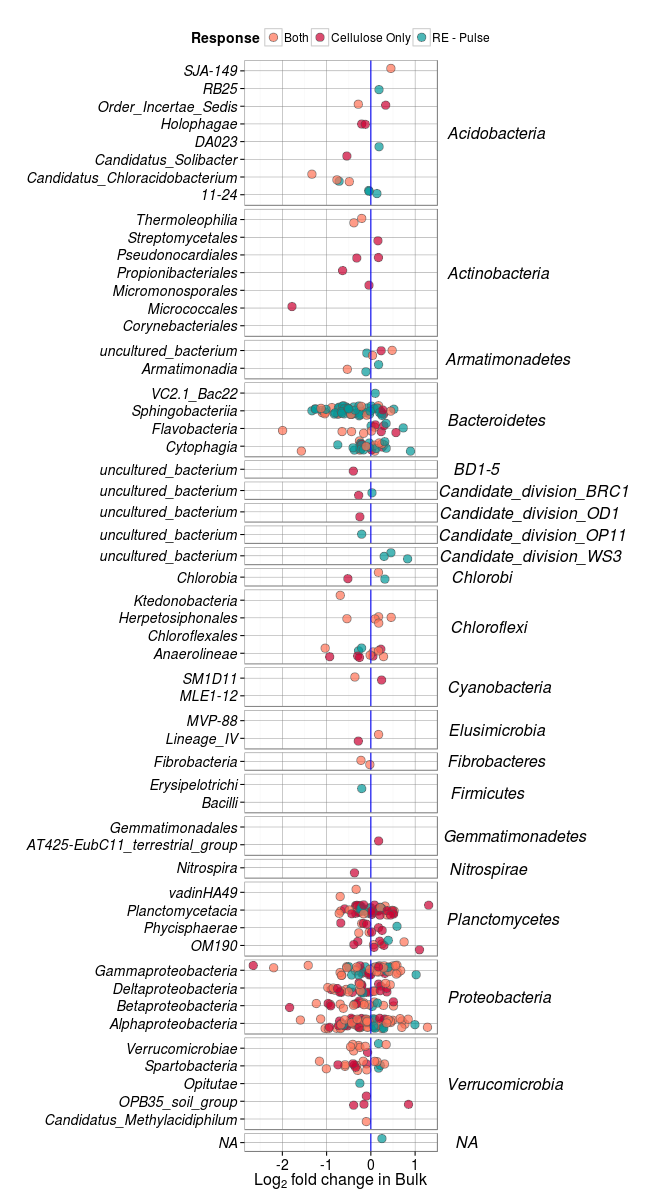

In [12]:
%%R -h 1200 -w 650

colours = c("coral1", "#CC0033", "#009999")

p = ggplot(df.rspnse.700.14, aes(y = Rank3, x = l2fc.bulk, fill = rspnse))

p = p + geom_point(size = 4, shape = 21, alpha = 0.7, position = position_jitter(h = 0.3, w = 0), color = "gray33")

p = p + facet_grid(Rank2 ~ ., scales = "free_y", space = "free")

p = p + geom_vline(xintercept = 0, color = "blue")

p = p + scale_fill_manual(values = colours, na.value = "black")

p = p + theme_bw()

p = p + labs(x = expression(paste(Log[2]," fold change in Bulk",sep="")), y = " ", fill = "Response")

p = p + theme(axis.text.y = element_text(size = 14, face = "italic"),
              axis.text.x = element_text(size = 14), 
              axis.title = element_text(size = 16),
              strip.text.y = element_text(angle = 0, hjust = 0.1, size = 16, face = "italic"),
              strip.background = element_blank(),
              panel.grid.major = element_line(colour = "#808080"),
              legend.position = "top",
              legend.title = element_text(size = 14),
              legend.text = element_text(size = 12))

p

In [13]:
%%R
#physeq.bulk = prune_samples((physeq.md$Treatment %in% c("12C100","13C100","12C700","13C700", "13CC", "12CC")) &
physeq.bulk.700.28 = prune_samples((physeq.md$Treatment %in% c("12C700","13C700", "13C000", "12C000")) &
                            (physeq.md$Bulk == "1") &
                            (physeq.md$Day == "28"),
                            physeq) 

physeq.bulk.700.28 = filter_taxa(physeq.bulk.700.28, function(x) sum(x) > 0, prune = TRUE)

physeq.bulk.700.28

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4838 taxa and 8 samples ]
sample_data() Sample Data:       [ 8 samples by 13 sample variables ]
tax_table()   Taxonomy Table:    [ 4838 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4838 tips and 4837 internal nodes ]


In [14]:
%%R
md = sample_data(physeq.bulk.700.28)
md$amendment = factor(ifelse(md$Treatment %in% c("12C700","13C700"),
                             "RE - Pulse",
                             "Cellulose Only"),
                      levels = c("RE - Pulse", "Cellulose Only"))
sample_data(physeq.bulk.700.28) = md

In [15]:
%%R
dds = phyloseq_to_deseq2(physeq.bulk.700.28, ~amendment)
dds = DESeq(dds, fitType = "local")

converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [16]:
%%R
df.bulk.700.28 = data.frame(results(dds, independentFiltering = FALSE)) %>%
    select(l2fc.bulk = log2FoldChange)
df.bulk.700.28$OTU = rownames(df.bulk.700.28)
head(df.bulk.700.28)

           l2fc.bulk       OTU
OTU.14353  0.1926745 OTU.14353
OTU.12843 -0.2368950 OTU.12843
OTU.12562 -0.2368950 OTU.12562
OTU.9794   0.1511028  OTU.9794
OTU.4204  -0.1111358  OTU.4204
OTU.467   -0.8373571   OTU.467


In [17]:
%%R
FDR = 0.10

rspnse = function(x, t) {
    ifelse(length(x) == 2, "Both", ifelse(t == "13C000", 
                                          "Cellulose Only", 
                                          "RE - Pulse"))
}

df.rspnse.700.28 = df.rspnse %>%
    filter(Treatment %in% c("13C000", "13C700")) %>%
    group_by(OTU, Treatment) %>%
    summarize(min.P = min(padj), 
              Rank2 = first(Rank2), 
              Rank3 = first(Rank3)) %>%
    filter(min.P <= FDR) %>%
    group_by(OTU) %>%
    summarize(rspnse = rspnse(min.P, Treatment), 
              Rank2 = first(Rank2),
              Rank3 = first(Rank3)) %>%
    left_join(df.bulk.700.28)

df.rspnse.700.28

Joining by: "OTU"
Source: local data frame [523 x 5]

         OTU         rspnse           Rank2                          Rank3
1      OTU.1 Cellulose Only  Actinobacteria                  Micrococcales
2     OTU.10           Both  Proteobacteria            Alphaproteobacteria
3   OTU.1009           Both   Bacteroidetes               Sphingobacteriia
4    OTU.101 Cellulose Only  Actinobacteria               Streptomycetales
5   OTU.1016     RE - Pulse   Acidobacteria                           RB25
6  OTU.10167           Both   Acidobacteria Candidatus_Chloracidobacterium
7  OTU.10192     RE - Pulse   Bacteroidetes                     Cytophagia
8    OTU.102           Both   Bacteroidetes               Sphingobacteriia
9  OTU.10213     RE - Pulse Verrucomicrobia               Verrucomicrobiae
10 OTU.10228           Both   Bacteroidetes                     Cytophagia
..       ...            ...             ...                            ...
Variables not shown: l2fc.bulk (dbl)


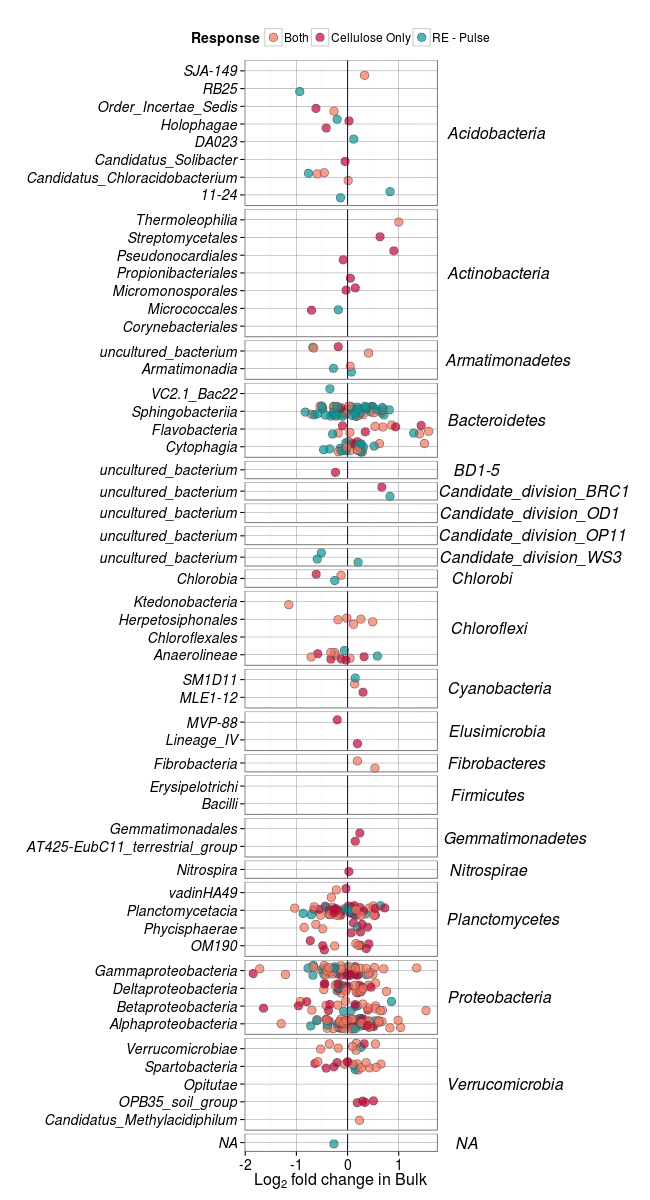

In [18]:
%%R -h 1200 -w 650

colours = c("coral1", "#CC0033", "#009999")

p2 = ggplot(df.rspnse.700.28, aes(y = Rank3, x = l2fc.bulk, fill = rspnse))

p2 = p2 + geom_point(size = 4, shape = 21, alpha = 0.7, position = position_jitter(h = 0.3, w = 0), color = "gray33")

p2 = p2 + facet_grid(Rank2 ~ ., scales = "free_y", space = "free")

p2 = p2 + geom_vline(xintercept = 0, color = "blue")

p2 = p2 + scale_fill_manual(values = colours, na.value = "black")

p2 = p2 + theme_bw()

p2 = p2 + labs(x = expression(paste(Log[2]," fold change in Bulk",sep="")), y = " ", fill = "Response")

p2 = p2 + theme(axis.text.y = element_text(size = 14, face = "italic"),
              axis.text.x = element_text(size = 14), 
              axis.title = element_text(size = 16),
              strip.text.y = element_text(angle = 0, hjust = 0.1, size = 16, face = "italic"),
              strip.background = element_blank(),
              panel.grid.major = element_line(colour = "#808080"),
              legend.position = "top",
              legend.title = element_text(size = 14),
              legend.text = element_text(size = 12))

p2

In [19]:
%%R
#physeq.bulk = prune_samples((physeq.md$Treatment %in% c("12C100","13C100","12C700","13C700", "13CC", "12CC")) &
physeq.bulk.700.45 = prune_samples((physeq.md$Treatment %in% c("12C700","13C700", "13C000", "12C000")) &
                            (physeq.md$Bulk == "1") &
                            (physeq.md$Day == "45"),
                            physeq) 

physeq.bulk.700.45 = filter_taxa(physeq.bulk.700.45, function(x) sum(x) > 0, prune = TRUE)

physeq.bulk.700.45

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 5752 taxa and 14 samples ]
sample_data() Sample Data:       [ 14 samples by 13 sample variables ]
tax_table()   Taxonomy Table:    [ 5752 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 5752 tips and 5751 internal nodes ]


In [20]:
%%R
md = sample_data(physeq.bulk.700.45)
md$amendment = factor(ifelse(md$Treatment %in% c("12C700","13C700"),
                             "RE - Pulse",
                             "Cellulose Only"),
                      levels = c("RE - Pulse", "Cellulose Only"))
sample_data(physeq.bulk.700.45) = md

In [21]:
%%R
dds = phyloseq_to_deseq2(physeq.bulk.700.45, ~amendment)
dds = DESeq(dds, fitType = "local")

converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 9 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [22]:
%%R
df.bulk.700.45 = data.frame(results(dds, independentFiltering = FALSE)) %>%
    select(l2fc.bulk = log2FoldChange)
df.bulk.700.45$OTU = rownames(df.bulk.700.45)
head(df.bulk.700.45)

            l2fc.bulk       OTU
OTU.12051  0.14788356 OTU.12051
OTU.12643  0.15886324 OTU.12643
OTU.4204  -0.21052345  OTU.4204
OTU.467    0.08572633   OTU.467
OTU.905    0.68340020   OTU.905
OTU.7253   0.94672764  OTU.7253


In [23]:
%%R
FDR = 0.10

rspnse = function(x, t) {
    ifelse(length(x) == 2, "Both", ifelse(t == "13C000", 
                                          "Cellulose Only", 
                                          "RE - Pulse"))
}

df.rspnse.700.45 = df.rspnse %>%
    filter(Treatment %in% c("13C000", "13C700")) %>%
    group_by(OTU, Treatment) %>%
    summarize(min.P = min(padj), 
              Rank2 = first(Rank2), 
              Rank3 = first(Rank3)) %>%
    filter(min.P <= FDR) %>%
    group_by(OTU) %>%
    summarize(rspnse = rspnse(min.P, Treatment), 
              Rank2 = first(Rank2),
              Rank3 = first(Rank3)) %>%
    left_join(df.bulk.700.45)

df.rspnse.700.45

Joining by: "OTU"
Source: local data frame [523 x 5]

         OTU         rspnse           Rank2                          Rank3
1      OTU.1 Cellulose Only  Actinobacteria                  Micrococcales
2     OTU.10           Both  Proteobacteria            Alphaproteobacteria
3   OTU.1009           Both   Bacteroidetes               Sphingobacteriia
4    OTU.101 Cellulose Only  Actinobacteria               Streptomycetales
5   OTU.1016     RE - Pulse   Acidobacteria                           RB25
6  OTU.10167           Both   Acidobacteria Candidatus_Chloracidobacterium
7  OTU.10192     RE - Pulse   Bacteroidetes                     Cytophagia
8    OTU.102           Both   Bacteroidetes               Sphingobacteriia
9  OTU.10213     RE - Pulse Verrucomicrobia               Verrucomicrobiae
10 OTU.10228           Both   Bacteroidetes                     Cytophagia
..       ...            ...             ...                            ...
Variables not shown: l2fc.bulk (dbl)


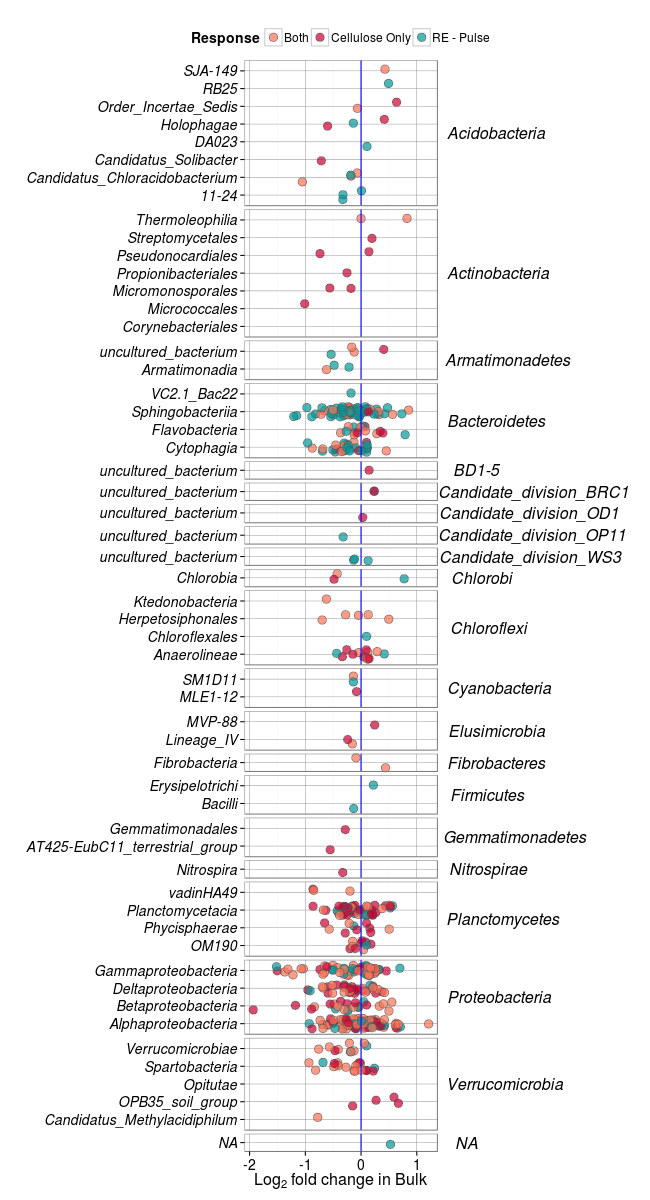

In [24]:
%%R -h 1200 -w 650

colours = c("coral1", "#CC0033", "#009999")

p3 = ggplot(df.rspnse.700.45, aes(y = Rank3, x = l2fc.bulk, fill = rspnse))

p3 = p3 + geom_point(size = 4, shape = 21, alpha = 0.7, position = position_jitter(h = 0.3, w = 0), color = "gray33")

p3 = p3 + facet_grid(Rank2 ~ ., scales = "free_y", space = "free")

p3 = p3 + geom_vline(xintercept = 0, color = "blue")

p3 = p3 + scale_fill_manual(values = colours, na.value = "black")

p3 = p3 + theme_bw()

p3 = p3 + labs(x = expression(paste(Log[2]," fold change in Bulk",sep="")), y = " ", fill = "Response")

p3 = p3 + theme(axis.text.y = element_text(size = 14, face = "italic"),
              axis.text.x = element_text(size = 14), 
              axis.title = element_text(size = 16),
              strip.text.y = element_text(angle = 0, hjust = 0.1, size = 16, face = "italic"),
              strip.background = element_blank(),
              panel.grid.major = element_line(colour = "#808080"),
              legend.position = "top",
              legend.title = element_text(size = 14),
              legend.text = element_text(size = 12))

p3

NULL


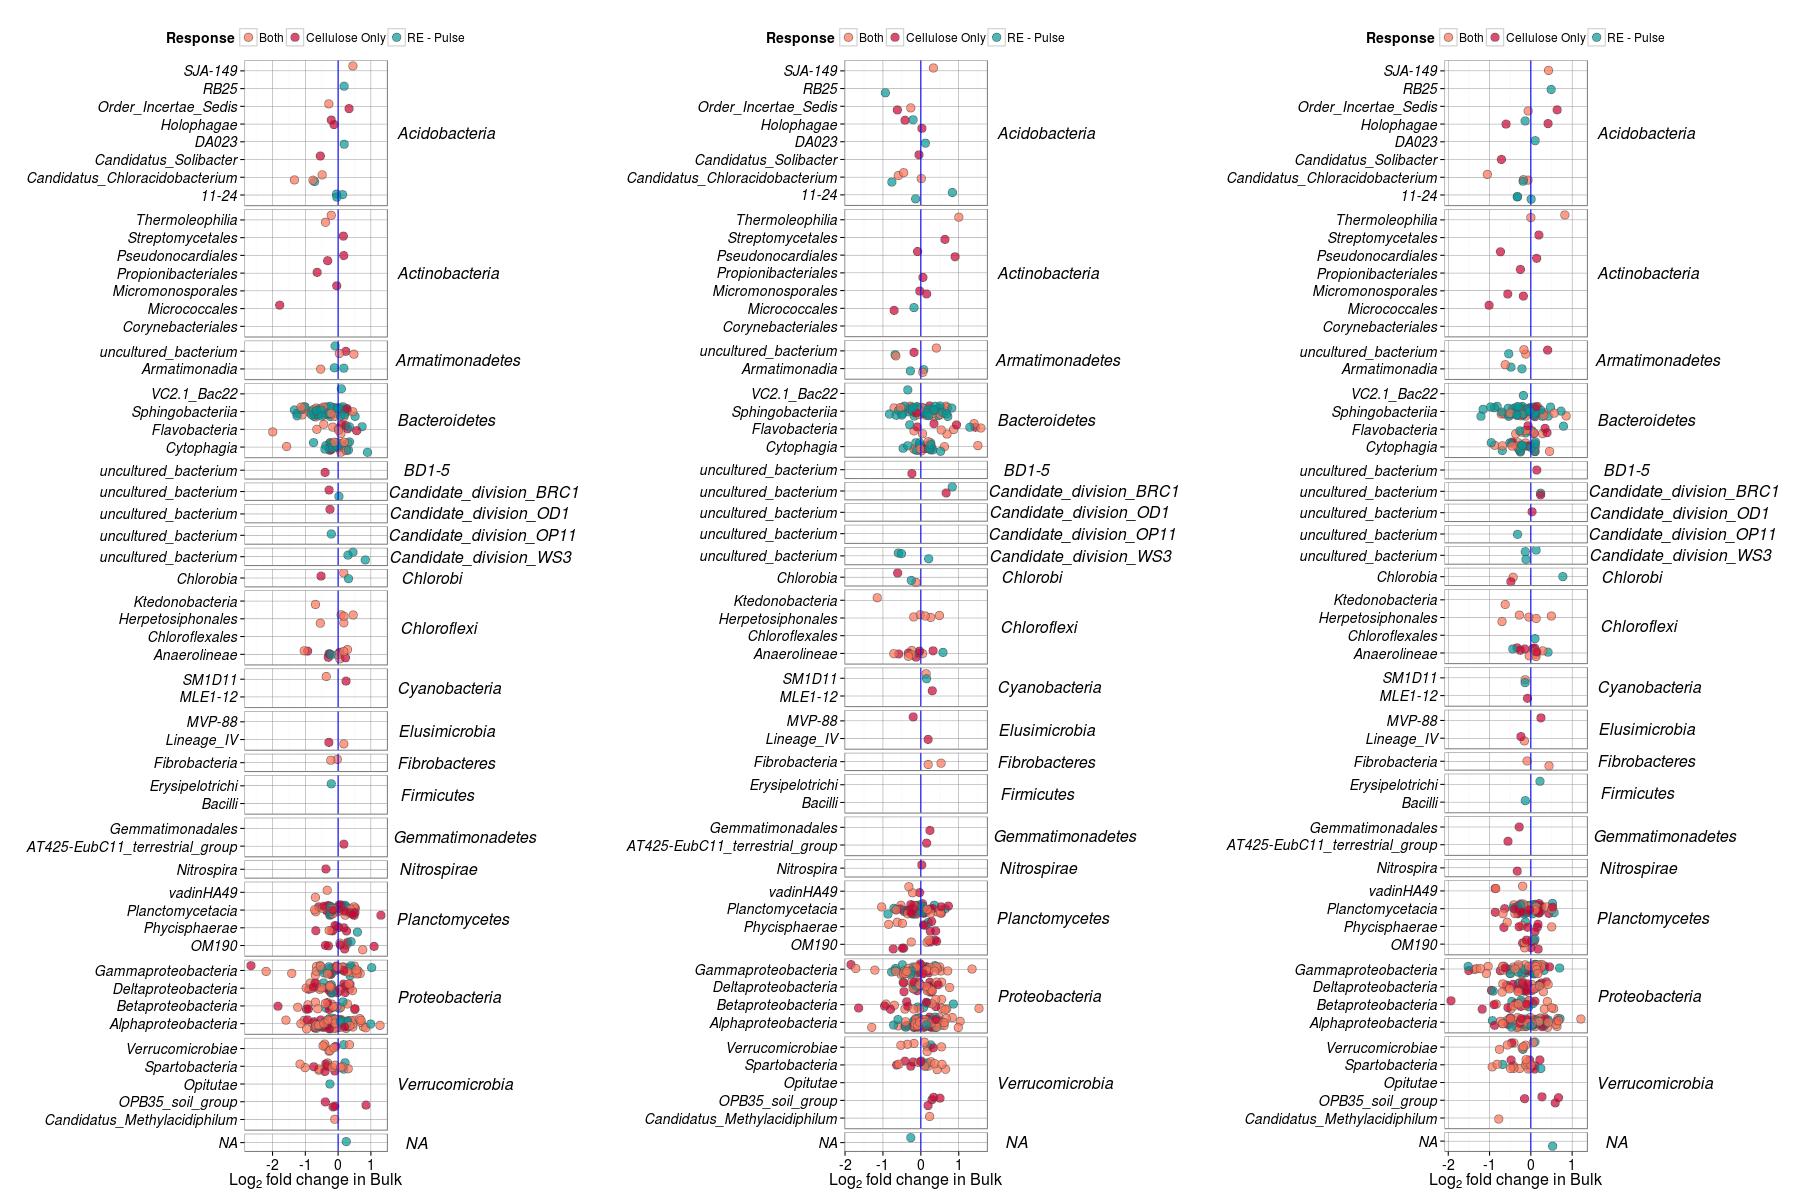

In [25]:
%%R -h 1200 -w 1800
p.combined = grid.arrange(p, p2, p3, ncol = 3)
p.combined

In [26]:
%%R -w 1000 -h 1200
pdf("figs/bulkl2fc_700_byday.pdf", width = 25, height = 17)
grid.arrange(p, p2, p3, ncol=3)
dev.off()

png 
  2 


In [27]:
FileLink("figs/bulkl2fc_700_byday.pdf")

/home/ashley/priming_exp/figs/bulkl2fc_700_byday.pdf

In [28]:
%%R 
png("figs/bulkl2fc_700_byday.png", width = 25, height = 17, units = "in", res = 600)
grid.arrange(p, p2, p3, ncol=3)
dev.off()

png 
  2 


In [29]:
FileLink("figs/bulkl2fc_700_byday.png")

/home/ashley/priming_exp/figs/bulkl2fc_700_byday.png